In [4]:
import sys
import urllib

from keras.layers import Dense, Flatten, Conv2D

from keras.models import Sequential, model_from_json
from keras.datasets import mnist
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import optimizers

import numpy as np
from PIL import Image
from io import BytesIO

from studio import fs_tracker, model_util, magics

### Set up learning parameters

In [5]:
batch_size = 128
no_epochs = 10
lr = 0.01

### Define model

In [6]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(10, activation='softmax'))
model.summary()
model_str = model.to_json()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


### Load data, train model

In [8]:
%%studio_run
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


model = model_from_json(model_str)

model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=lr),
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    fs_tracker.get_model_directory() +
    '/checkpoint.{epoch:02d}-{val_loss:.2f}.hdf')

tbcallback = TensorBoard(log_dir=fs_tracker.get_tensorboard_dir(),
                         histogram_freq=0,
                         write_graph=True,
                         write_images=True)

training_stats = model.fit(
    x_train, y_train, validation_data=(
        x_test,
        y_test),
    epochs=no_epochs,
    callbacks=[checkpointer, tbcallback],
    batch_size=batch_size)

history = training_stats.history

# clean up large data to prevent it being sent back
x_train = None
y_train = None
x_test = None
y_test = None

Running studio with experiment key 18979623-8553-45c9-9f07-2d2d485877c1
Experiment progress can be viewed/shared at:
https://20171022t133148-dot-studio-ed756.appspot.com/experiment/18979623-8553-45c9-9f07-2d2d485877c1
studio-run --capture=/Users/peter.zhokhov/.studioml/experiments/18979623-8553-45c9-9f07-2d2d485877c1/_ns:_ns --force-git --experiment=18979623-8553-45c9-9f07-2d2d485877c1 _script.py
Using TensorFlow backend.
2017-10-23 10:19:50.647875: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-10-23 10:19:50.648012: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-10-23 10:19:50.648027: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX

### Visualize results

In [9]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

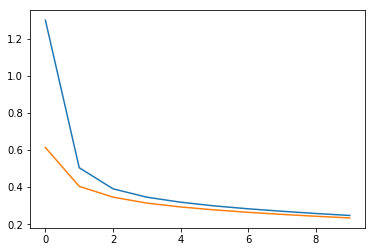

In [10]:
plt.plot(range(no_epochs), history['loss'], range(no_epochs), history['val_loss'])